# Sales Forecast Using LSTM

In [48]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#pip install keras
#pip install tensorflow

In [49]:
import warnings
warnings.filterwarnings("ignore")

In [50]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly as py

In [51]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [52]:
xls = pd.ExcelFile('Monthly Sales for Laptops - Project Data.xlsx')
xls.sheet_names

['Sales and Budget']

In [53]:
df = pd.read_excel (xls)
df.head(10)

,Month,Sales,Budget
0,2015-01-01,14840.0,13740.0
1,2015-02-01,14820.0,16466.0
2,2015-03-01,17920.0,18474.0
3,2015-04-01,19020.0,17449.0
4,2015-05-01,20600.0,22150.0
5,2015-06-01,13940.0,12907.0
6,2015-07-01,14000.0,13084.0
7,2015-08-01,15860.0,17622.0
8,2015-09-01,17220.0,17571.0
9,2015-10-01,20640.0,19111.0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   72 non-null     datetime64[ns]
 1   Sales   60 non-null     float64       
 2   Budget  72 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.8 KB


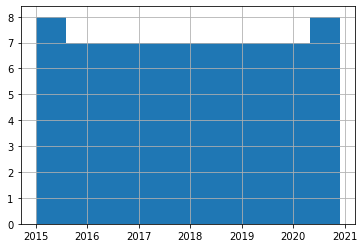

In [55]:
df.Month.hist()

In [56]:
df.isnull().sum()

Month      0
Sales     12
Budget     0
dtype: int64

In [57]:
df[df.Sales.isnull()]

,Month,Sales,Budget
60,2020-01-01,NaN,35200.0
61,2020-02-01,NaN,31240.0
62,2020-03-01,NaN,21362.0
63,2020-04-01,NaN,23452.0
64,2020-05-01,NaN,25740.0
65,2020-06-01,NaN,30866.0
66,2020-07-01,NaN,24618.0
67,2020-08-01,NaN,17226.0
68,2020-09-01,NaN,19822.0
69,2020-10-01,NaN,22506.0


In [58]:
mask=df.Sales.isnull()

df_sales=df[~mask]

In [59]:
df_sales.isnull().sum()

Month     0
Sales     0
Budget    0
dtype: int64

In [60]:
df_sales.Month.describe()

count                      60
unique                     60
top       2018-10-01 00:00:00
freq                        1
first     2015-01-01 00:00:00
last      2019-12-01 00:00:00
Name: Month, dtype: object

1. Plot Monthly Sales

In [61]:
#plot monthly sales
plot_data = [
    go.Scatter(
        x=df_sales['Month'],
        y=df_sales['Sales'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

In [62]:
df_sales.tail(12)

,Month,Sales,Budget
48,2019-01-01,32000.0,33333.0
49,2019-02-01,28400.0,27307.0
50,2019-03-01,19420.0,18149.0
51,2019-04-01,21320.0,23955.0
52,2019-05-01,23400.0,24893.0
53,2019-06-01,28060.0,29229.0
54,2019-07-01,22380.0,21113.0
55,2019-08-01,15660.0,14635.0
56,2019-09-01,18020.0,16381.0
57,2019-10-01,20460.0,19673.0


There is a strong sales peak at Black-Friday times (November) and Christmas times (December), followed by a dip shortly thereafter.

In [63]:
#create a new dataframe for model prediction
df_diff= df.copy()
#add previous sales
df_diff['prev_sales'] = df_diff['Sales'].shift(1)
#drop the null values and calculate the difference

#df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['Sales'] - df_diff['prev_sales'])
df_diff.tail(24)

,Month,Sales,Budget,prev_sales,diff
48,2019-01-01,32000.0,33333.0,58120.0,-26120.0
49,2019-02-01,28400.0,27307.0,32000.0,-3600.0
50,2019-03-01,19420.0,18149.0,28400.0,-8980.0
51,2019-04-01,21320.0,23955.0,19420.0,1900.0
52,2019-05-01,23400.0,24893.0,21320.0,2080.0
53,2019-06-01,28060.0,29229.0,23400.0,4660.0
54,2019-07-01,22380.0,21113.0,28060.0,-5680.0
55,2019-08-01,15660.0,14635.0,22380.0,-6720.0
56,2019-09-01,18020.0,16381.0,15660.0,2360.0
57,2019-10-01,20460.0,19673.0,18020.0,2440.0


2. Plot monthly difference

In [64]:
#plot sales diff
df_diff2= df_diff.dropna()

plot_data = [
    go.Scatter(
        x=df_diff2['Month'],
        y=df_diff2['diff'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

3. Use previous mothly sales to predict next month

In [65]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)

#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)


In [66]:
df_supervised.tail(24)

,Month,Sales,Budget,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
23,2018-01-01,26980.0,25214.0,-21660.0,-15800.0,34720.0,3660.0,260.0,2500.0,-9440.0,4300.0,1920.0,2060.0,2320.0,-7220.0,-21600.0
24,2018-02-01,28720.0,30231.0,1740.0,-21660.0,-15800.0,34720.0,3660.0,260.0,2500.0,-9440.0,4300.0,1920.0,2060.0,2320.0,-7220.0
25,2018-03-01,31100.0,34175.0,2380.0,1740.0,-21660.0,-15800.0,34720.0,3660.0,260.0,2500.0,-9440.0,4300.0,1920.0,2060.0,2320.0
26,2018-04-01,32160.0,29236.0,1060.0,2380.0,1740.0,-21660.0,-15800.0,34720.0,3660.0,260.0,2500.0,-9440.0,4300.0,1920.0,2060.0
27,2018-05-01,24160.0,24160.0,-8000.0,1060.0,2380.0,1740.0,-21660.0,-15800.0,34720.0,3660.0,260.0,2500.0,-9440.0,4300.0,1920.0
28,2018-06-01,26820.0,25542.0,2660.0,-8000.0,1060.0,2380.0,1740.0,-21660.0,-15800.0,34720.0,3660.0,260.0,2500.0,-9440.0,4300.0
29,2018-07-01,29460.0,29168.0,2640.0,2660.0,-8000.0,1060.0,2380.0,1740.0,-21660.0,-15800.0,34720.0,3660.0,260.0,2500.0,-9440.0
30,2018-08-01,32080.0,31145.0,2620.0,2640.0,2660.0,-8000.0,1060.0,2380.0,1740.0,-21660.0,-15800.0,34720.0,3660.0,260.0,2500.0
31,2018-09-01,30560.0,32860.0,-1520.0,2620.0,2640.0,2660.0,-8000.0,1060.0,2380.0,1740.0,-21660.0,-15800.0,34720.0,3660.0,260.0
32,2018-10-01,22620.0,21961.0,-7940.0,-1520.0,2620.0,2640.0,2660.0,-8000.0,1060.0,2380.0,1740.0,-21660.0,-15800.0,34720.0,3660.0


4. Check how well features explains the variation

In [67]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.6323410038078252


Entire features (lag1~12) explains 63% of the variation (not too impressive)

5. Build LSTM Model Test with Actual Sales

In [68]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['Sales','Budget','Month'],axis=1)

#split train and test set 
train_set, test_set = df_model[0:-6].values, df_model[-6:].values

In [69]:
df_model.tail(12)

,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
35,-26120.0,6280.0,29220.0,-7940.0,-1520.0,2620.0,2640.0,2660.0,-8000.0,1060.0,2380.0,1740.0,-21660.0
36,-3600.0,-26120.0,6280.0,29220.0,-7940.0,-1520.0,2620.0,2640.0,2660.0,-8000.0,1060.0,2380.0,1740.0
37,-8980.0,-3600.0,-26120.0,6280.0,29220.0,-7940.0,-1520.0,2620.0,2640.0,2660.0,-8000.0,1060.0,2380.0
38,1900.0,-8980.0,-3600.0,-26120.0,6280.0,29220.0,-7940.0,-1520.0,2620.0,2640.0,2660.0,-8000.0,1060.0
39,2080.0,1900.0,-8980.0,-3600.0,-26120.0,6280.0,29220.0,-7940.0,-1520.0,2620.0,2640.0,2660.0,-8000.0
40,4660.0,2080.0,1900.0,-8980.0,-3600.0,-26120.0,6280.0,29220.0,-7940.0,-1520.0,2620.0,2640.0,2660.0
41,-5680.0,4660.0,2080.0,1900.0,-8980.0,-3600.0,-26120.0,6280.0,29220.0,-7940.0,-1520.0,2620.0,2640.0
42,-6720.0,-5680.0,4660.0,2080.0,1900.0,-8980.0,-3600.0,-26120.0,6280.0,29220.0,-7940.0,-1520.0,2620.0
43,2360.0,-6720.0,-5680.0,4660.0,2080.0,1900.0,-8980.0,-3600.0,-26120.0,6280.0,29220.0,-7940.0,-1520.0
44,2440.0,2360.0,-6720.0,-5680.0,4660.0,2080.0,1900.0,-8980.0,-3600.0,-26120.0,6280.0,29220.0,-7940.0


In [70]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [71]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [72]:
import keras.models
from keras.models import Sequential
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
41/41 [==============================] - 0s 854us/step - loss: 0.1817
Epoch 2/100
41/41 [==============================] - 0s 902us/step - loss: 0.1741
Epoch 3/100
41/41 [==============================] - 0s 805us/step - loss: 0.1549
Epoch 4/100
41/41 [==============================] - 0s 707us/step - loss: 0.1413
Epoch 5/100
41/41 [==============================] - 0s 805us/step - loss: 0.1335
Epoch 6/100
41/41 [==============================] - 0s 811us/step - loss: 0.1293
Epoch 7/100
41/41 [==============================] - 0s 732us/step - loss: 0.1265
Epoch 8/100
41/41 [==============================] - 0s 683us/step - loss: 0.1240
Epoch 9/100
41/41 [==============================] - 0s 683us/step - loss: 0.1215
Epoch 10/100
41/41 [==============================] - 0s 732us/step - loss: 0.1190
Epoch 11/100
41/41 [==============================] - 0s 878us/step - loss: 0.1163
Epoch 12/100
41/41 [==============================] - 0s 780us/step - loss: 0.1135
Epoch 13/100


41/41 [==============================] - 0s 829us/step - loss: 0.0130
Epoch 100/100
41/41 [==============================] - 0s 805us/step - loss: 0.0129


In [73]:
y_pred = model.predict(X_test,batch_size=1)

In [74]:
y_pred

array([[-0.22029802],
       [ 0.02077123],
       [-0.24889365],
       [-0.22034088],
       [ 0.8078413 ],
       [-0.17985606]], dtype=float32)

In [75]:
y_test

array([[-0.32807364],
       [-0.36226167],
       [-0.06377383],
       [-0.06114398],
       [ 0.77580539],
       [-0.39907955]])

In [76]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[-0.22029802  0.01183432 -0.0729783  -0.07889546 -0.4365549  -0.25969757
  -1.15821213 -0.00886839  0.80489535 -0.51330259 -0.28556226 -0.13870167
  -0.1379922 ]]
[[ 0.02077123 -0.32807364  0.01183432 -0.0729783  -0.07889546 -0.4365549
  -0.35934729 -1.15821213 -0.00886839  0.80489535 -0.51330259 -0.28556226
  -0.13870167]]
[[-0.24889365 -0.36226167 -0.32807364  0.01183432 -0.0729783  -0.07889546
  -0.5501951  -0.35934729 -1.15821213 -0.00886839  0.80489535 -0.51330259
  -0.28556226]]
[[-0.22034088 -0.06377383 -0.36226167 -0.32807364  0.01183432 -0.0729783
  -0.16424264 -0.5501951  -0.35934729 -1.15821213 -0.00886839  0.80489535
  -0.51330259]]
[[ 0.8078413  -0.06114398 -0.06377383 -0.36226167 -0.32807364  0.01183432
  -0.1578574  -0.16424264 -0.5501951  -0.35934729 -1.15821213 -0.00886839
   0.80489535]]
[[-0.17985606  0.77580539 -0.06114398 -0.06377383 -0.36226167 -0.32807364
  -0.06633558 -0.1578574  -0.16424264 -0.5501951  -0.35934729 -1.15821213
  -0.00886839]]


In [77]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-7:].Month)
act_sales = list(df_sales[-7:].Sales)

    
    

In [78]:
sales_dates

[Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00')]

In [79]:
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['Month'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [80]:
df_result.tail()

,pred_value,Month
1,27311,2019-08-01
2,12388,2019-09-01
3,15617,2019-10-01
4,49334,2019-11-01
5,47188,2019-12-01


In [81]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_sales,df_result,on='Month',how='left')
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df_sales_pred['Month'],
        y=df_sales_pred['Sales'],
        name='actual'
    ),
        go.Scatter(
        x=df_sales_pred['Month'],
        y=df_sales_pred['pred_value'],
        name='predicted'
    )
    
]
plot_layout = go.Layout(
        title='Sales Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()